$\textbf{Libraries}$

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
%matplotlib inline

$\textbf{Importing Dataset}$

In [2]:
# Testing Data points
Xte0 = pd.read_csv('Xte0.csv',index_col="Id")
Xte1 = pd.read_csv('Xte1.csv',index_col="Id")
Xte2 = pd.read_csv('Xte2.csv',index_col="Id")
Xte = pd.concat([Xte0,Xte1,Xte2])

In [3]:
# Training Data points
Xtr0 = pd.read_csv('Xtr0.csv',index_col="Id")
Xtr1 = pd.read_csv('Xtr1.csv',index_col="Id")
Xtr2 = pd.read_csv('Xtr2.csv',index_col="Id")
Xtr = pd.concat([Xtr0,Xtr1,Xtr2])

# Training labels
Ytr0 = pd.read_csv('Ytr0.csv',index_col="Id")
Ytr1 = pd.read_csv('Ytr1.csv',index_col="Id")
Ytr2 = pd.read_csv('Ytr2.csv',index_col="Id")
Ytr = pd.concat([Ytr0,Ytr1,Ytr2])

In [4]:
Xtr0_np=Xtr0.to_numpy().reshape(-1)
Ytr0_np=Ytr0.to_numpy().reshape(-1)
Xte0_np=Xte0.to_numpy().reshape(-1)

Xtr1_np=Xtr1.to_numpy().reshape(-1)
Ytr1_np=Ytr1.to_numpy().reshape(-1)
Xte1_np=Xte1.to_numpy().reshape(-1)

Xtr2_np=Xtr2.to_numpy().reshape(-1)
Ytr2_np=Ytr2.to_numpy().reshape(-1)
Xte2_np=Xte2.to_numpy().reshape(-1)

[]

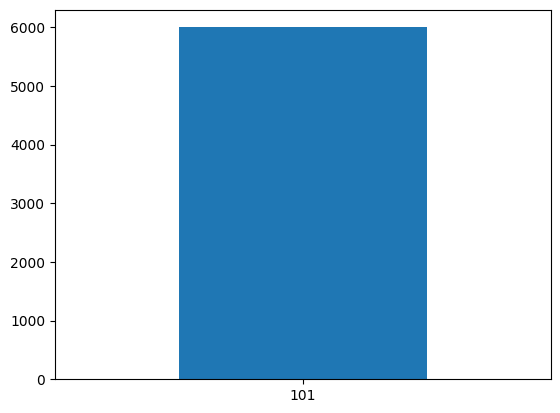

In [6]:
def seq_length(seq):
    return len(seq)

seq_len=Xtr['seq'].apply(seq_length)
seq_len.value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.plot()

$\textbf{Kernels}$

$\textit{Spectrum Kernel}$

In [7]:
import numpy as np
from collections import defaultdict

class DNATrieNode:
    """A node in the DNA sequence trie."""
    
    def __init__(self):
        # Each node has 4 children, one for each DNA base (A, C, G, T)
        # Using a dictionary for clarity, but could use array for better performance
        self.children = {'A': None, 'C': None, 'G': None, 'T': None}
        # Sequences that contain the k-mer represented by the path to this node
        self.sequence_counts = defaultdict(int)
        

class SpectrumKernel:
    """
    Implementation of the spectrum kernel using a trie data structure for efficient
    k-mer counting in DNA sequences.
    """
    
    def __init__(self,k=6):
        """
        Initialize the spectrum kernel with a given k-mer length.
        
        Parameters:
        -----------
        k : int
            Length of k-mers to consider
        """
        self.k = k
        
    def _insert_kmer(self,kmer,seq_idx):
        """
        Insert a k-mer into the trie and associate it with a sequence index.
        
        Parameters:
        -----------
        kmer : str
            The k-mer to insert
        seq_idx : int
            Index of the sequence containing this k-mer
        """
        node = self.root
        
        # Traverse the trie, creating nodes as needed
        for base in kmer:
            if base not in 'ACGT':
                return  # Skip k-mers with non-DNA characters
                
            if node.children[base] is None:
                node.children[base] = DNATrieNode()
            
            node = node.children[base]
        
        # Increment the count for this sequence at the terminal node
        node.sequence_counts[seq_idx] += 1
        
    def add_sequences(self, sequences):
        """
        Add sequences to the trie by inserting the k-mers of each one. 
        
        Parameters:
        -----------
        sequences : str
            DNA sequences to add
        
        Returns:
        --------
        int
            Index of the added sequences
        """
        for seq in range(len(sequences)):
            sequence = sequences[seq]
            seq_idx = len(self.sequences)
            self.sequences.append(sequence)
            
            # Insert all k-mers from the sequence
            for i in range(len(sequence) - self.k + 1):
                kmer = sequence[i:i+self.k]
                self._insert_kmer(kmer, seq_idx)
            
        return seq_idx
    
    def compute_kernel_matrix(self,X,Y):
        """
        Compute the kernel matrix for all added sequences.
        
        Returns:
        --------
        numpy.ndarray
            Kernel matrix where K[i,j] is the similarity between sequences i and j
        """
        self.root = DNATrieNode()
        self.sequences = []

        self.add_sequences(X)
        self.add_sequences(Y)

        n1 = len(X)
        n2 = len(Y)
        K = np.zeros([n1, n2])

        # Traverse the trie and update the kernel matrix based on shared k-mers
        def traverse_and_compute(node):
            if not any(node.children.values()):
                # We're at a leaf, calculate contribution to kernel matrix
                counts = node.sequence_counts
                for i in counts :
                    for j in counts:
                        if i<n1 and j>=n1:
                            K[i, j-n1] += counts[i] * counts[j]
                return
            
            # Recursive traversal
            for base, child in node.children.items():
                if child:
                    traverse_and_compute(child)
        
        traverse_and_compute(self.root)
        return K

$\textit{Substring Kernels}$

In [8]:
def B(k,x1,x2,lmd=0.5):
    n = len(x1)
    dp1 = np.ones([1,n,n])
    dp2 = np.zeros([k,n,n])
    dp = np.concatenate([dp1,dp2],axis=0)
    
    for k_val in range(1,k+1):
        if k_val == 1:
            dp[k_val,0,0] = (x1[0]==x2[0])*(lmd**2)
            for idx in range(1,n):
                dp[k_val,idx,0] = (lmd**2) * dp[k_val,idx-1,0] + (x2[0]==x1[idx]) * (lmd**2)
                dp[k_val,0,idx] = (lmd**2) * dp[k_val,idx-1,0] + (x1[0]==x2[idx]) * (lmd**2)
        for i in range(1,n):
            for j in range(1,n):
                dp[k_val][i][j] = (lmd * dp[k_val][i-1][j] +
                                   lmd * dp[k_val][i][j-1] -
                                   lmd**2 * dp[k_val][i-1][j-1] +
                                   (x1[i-1] == x2[j-1]) * lmd**2 * dp[k_val-1][i-1][j-1])
    
    return dp

def SSKernel(k,x1,x2,lmd=0.5):
    n = len(x1)
    B_k = B(k-1, x1[:-1], x2[:-1], lmd)
    K = 0 
    for idx_x1 in range(k,n):
        for idx_x2 in range(k,n):
            K += (x2[idx_x2]==x1[idx_x1]) * B_k[k-1,idx_x1-1,idx_x2-1]
    return K 

def SSKernel_Matrix(k,X,lmd=0.5):
    K = np.zeros([len(X),len(X)])
    for i in range(len(X)):
        for j in range(i,len(X)):
            K[i,j]=SSKernel(k,X[i],X[j],lmd)
            K[j,i]=K[i,j]
    return K 

$\textbf{Kernel Methods}$

$\textit{Kernel Ridge Regression}$

In [25]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

class KernelRidgeRegression(BaseEstimator, RegressorMixin):
    """
    Custom implementation of Kernel Ridge Regression
    
    Parameters:
    -----------
    kernel_fn : callable
        The kernel function to use. Should take two arrays X and Y and return the kernel matrix.
    alpha : float, default=1.0
        Regularization strength. Larger values specify stronger regularization.
    """
    
    def __init__(self, kernel_fn, alpha=1.0):
        self.kernel_fn = kernel_fn
        self.alpha = alpha
        self.X_train = None
        self.dual_coef_ = None
        
    def fit(self, X, y):
        """
        Fit the kernel ridge regression model.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data
        y : array-like of shape (n_samples,)
            Target values
            
        Returns:
        --------
        self : returns an instance of self.
        """
        # Store training data
        self.X_train = X
        
        # Compute the kernel matrix
        K = self.kernel_fn(X, X)
        
        # Add regularization to the diagonal
        K_reg = K + self.alpha * np.eye(K.shape[0])
        
        # Solve for dual coefficients: (K + αI)α = y
        self.dual_coef_ = np.linalg.solve(K_reg, y)
        
        return self
    
    def predict(self, X):
        """
        Predict using the kernel ridge model.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Samples
            
        Returns:
        --------
        y_pred : ndarray of shape (n_samples,)
            Predicted values
        """
        # Compute kernel between test points and training points
        K_test = self.kernel_fn(X, self.X_train)
        
        # Make predictions
        y_pred = K_test.dot(self.dual_coef_)
        
        return (y_pred>0) * 1

$\textit{Support Vector Classifier}$

In [24]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None # support vectors
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        K = self.kernel(X,X) # the gram matrix 
        self.X = X
        self.y = y
        # Lagrange dual problem
        def loss(alpha):
            s_1 = np.sum(alpha)

            weighted_labels = y*alpha
            s_2=np.dot(weighted_labels.T,np.dot(K,weighted_labels))

            return  s_1-(1/2)*s_2

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            weighted_labels = y*alpha
            return 1 - y * np.dot(K,weighted_labels)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha:  np.dot(y,alpha) # '''----------------function defining the equality constraint------------------'''        
        jac_eq = lambda alpha:  y   #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        fun_ineq = lambda alpha:  np.hstack([self.C-alpha,alpha]) # '''---------------function defining the inequality constraint-------------------'''     
        jac_ineq = lambda alpha:  np.vstack([-np.eye(N),np.eye(N)]) # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes

        #'''------------------- A matrix with each row corresponding to support vectors ------------------'''

        self.support =  X[self.alpha>0] 

        #''' -----------------offset of the classifier------------------ '''

        ind1 = self.alpha>0
        ind2 = self.alpha<self.C
        ind_verif = ind1*ind2 # datapoints having their respective 0<alpha_i<C
        indices = np.arange(N)[ind_verif]
        f_opt = lambda i: np.dot(K[i],y*self.alpha)

        self.b = np.mean(1/y[indices]-f_opt(indices)) 

        # '''------------------------RKHS norm of the function f ------------------------------'''

        weighted_labels = y*self.alpha

        self.norm_f = np.dot(weighted_labels.T,np.dot(K,weighted_labels)) 

    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K_pred = self.kernel(self.X,x).T
        return np.dot(K_pred,self.alpha*self.y)
    
    
    def predict(self, X):
        """ Predict y values in {0, 1} """
        d = self.separating_function(X)
        return (d+self.b> 0) * 1

$\textbf{Training}$

In [43]:
kernel = SpectrumKernel().compute_kernel_matrix
model = KernelRidgeRegression(kernel_fn=kernel,alpha=0.1)

In [44]:
model.fit(Xtr0_np,Ytr0_np)
Y_pred0=model.predict(Xte0_np) 

In [45]:
model.fit(Xtr1_np,Ytr1_np)
Y_pred1=model.predict(Xte1_np) 

In [46]:
model.fit(Xtr2_np,Ytr2_np)
Y_pred2=model.predict(Xte2_np) 

In [32]:
np.sum(Y_pred0==Ytr0_np)/len(Ytr0_np)

0.632

$\textbf{Submission}$

In [47]:
Y_pred = np.concatenate([Y_pred0,Y_pred1,Y_pred2])
submission = pd.DataFrame({"Id": range(len(Y_pred)), "Bound": Y_pred})
submission.to_csv("submission_KRR_alpha=0.1.csv",header=True,index=False)